# Convolutions

Deeksha 171EC113
Varun 171EC251
Niranjan 171EC130

# Question 1

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import time
from numpy.lib.stride_tricks import as_strided


### Function to construct Doubly Blocked Toeplitz Matrix

In [2]:
def doubly_block_toeplitz(I,F):
    # Input, Output Dimensions
    I_row_num, I_col_num = I.shape 
    F_row_num, F_col_num = F.shape
    output_row_num = I_row_num + F_row_num - 1
    output_col_num = I_col_num + F_col_num - 1
    print('Output dimension:', output_row_num, output_col_num)

    # Padding the Filter
    F_zero_padded = np.pad(F, ((output_row_num - F_row_num, 0), (0, output_col_num - F_col_num)),'constant', constant_values=0)
    print('Padded Filter Shape: ', F_zero_padded.shape)
    
    # Use each row of the zero-padded F to create a toeplitz matrix. 
    toeplitz_list = []
    for i in range(F_zero_padded.shape[0]-1, -1, -1): # iterate from last row to the first row
        c = F_zero_padded[i, :]                       # i th row of the Filter 
        r = np.r_[c[0], np.zeros(I_col_num-1)]        # first row for the toeplitz matrix
        toeplitz_m = toeplitz_1d(c,r)                 # Calling function for 1D toeplitz
        toeplitz_list.append(toeplitz_m)
    
    c = range(1, F_zero_padded.shape[0]+1)
    r = np.r_[c[0], np.zeros(I_row_num-1, dtype=int)]
    doubly_indices = toeplitz_1d(c, r)

    # Initialize doubly blocked matrix with zero values
    toeplitz_shape = toeplitz_list[0].shape            # shape of one toeplitz matrix
    h = toeplitz_shape[0]*doubly_indices.shape[0]
    w = toeplitz_shape[1]*doubly_indices.shape[1]
    doubly_blocked_shape = [h, w]
    doubly_blocked = np.zeros(doubly_blocked_shape)

    # Stack toeplitz matrices for each row in the doubly blocked matrix
    b_h, b_w = toeplitz_shape 
    for i in range(doubly_indices.shape[0]):
        for j in range(doubly_indices.shape[1]):
            start_i = i * b_h
            start_j = j * b_w
            end_i = start_i + b_h
            end_j = start_j + b_w
            doubly_blocked[start_i: end_i, start_j:end_j] = toeplitz_list[doubly_indices[i,j]-1]

    print('Shape of doubly_blocked Toeplitz Matrix is : ', doubly_blocked.shape)
#     print('doubly_blocked Toeplitz Matrix is: ', doubly_blocked)
    return doubly_blocked


### Multiply doubly blocked toeplitz matrix with vectorized input signal

In [3]:
def toeplitz_conv2d(doubly_blocked, I, F):
    
    # Converting input to vector
    vectorized_I = matrix_to_vector(I)
#     print('Vectorized Input: ', vectorized_I)

    # Result of convolution by matrix mupltiplication
    result_vector = np.matmul(doubly_blocked, vectorized_I)
    
    output_row_num = I.shape[0] + F.shape[0] - 1
    output_col_num = I.shape[1] + F.shape[1] - 1
    

    # reshape the raw result to desired matrix form
    out_shape = [output_row_num, output_col_num]
    my_output = vector_to_matrix(result_vector, out_shape)
    
    return my_output

#     print('Result of Convolution using doubly blocked Toeplitz method: \n', my_output)

### Helper Functions

In [4]:
# 1D Toeplitz Matrix Construction 
def toeplitz_1d(c,r):
    c = np.asarray(c).ravel()
    if r is None:
        r = c.conjugate()
    else:
        r = np.asarray(r).ravel()

    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

#Converting matrix to vector
def matrix_to_vector(input):
    input_h, input_w = input.shape
    output_vector = np.zeros(input_h*input_w, dtype=input.dtype)
    input = np.flipud(input) 
    for i,row in enumerate(input):
        st = i*input_w
        nd = st + input_w
        output_vector[st:nd] = row
        
    return output_vector

#Converting vector to matrix
def vector_to_matrix(input, output_shape):
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=input.dtype)
    for i in range(output_h):
        st = i*output_w
        nd = st + output_w
        output[i, :] = input[st:nd]
    # flip the output matrix up-down to get correct result
    output=np.flipud(output)
    return output

## Question 1a - Conv using Doubly Toeplitz Matrix between input array and filter

In [5]:
# input signal
I = np.array([[1,2,3],[4,5,6],[7,8,9]])
print('I: ', I.shape)
print(I)

# filter 
F = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
print('F: ',F.shape)
print(F)

I:  (3, 3)
[[1 2 3]
 [4 5 6]
 [7 8 9]]
F:  (3, 3)
[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


In [6]:
doubly_blocked = doubly_block_toeplitz(I,F) # Doubly Blocked Toeplitz Matrix

Output dimension: 5 5
Padded Filter Shape:  (5, 5)
Shape of doubly_blocked Toeplitz Matrix is :  (25, 9)


In [7]:
conv2d_result = toeplitz_conv2d(doubly_blocked, I, F) # Convolution Result

## Question 1b - Convolution by  Doubly Block Toeplitz matrix method between input image(lena.jpg) and filter 

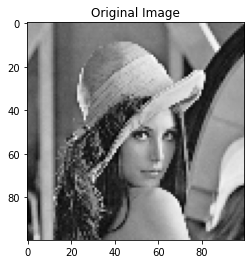

In [8]:
img = cv2.imread('lenna.tif',0)
I = cv2.resize(img,(100,100))
F = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])/16
plt.imshow(I,cmap='gray')
plt.title("Original Image")
plt.show()


#### Convolution using Doubly Blocked Toeplitz Matrix

In [9]:
t0 = time.time()
doubly_blocked = doubly_block_toeplitz(I,F)           # Doubly Blocked Toeplitz Matrix
conv2d_result = toeplitz_conv2d(doubly_blocked, I, F) # Convolution Result
t1 = time.time()
toep_time = t1-t0

Output dimension: 102 102
Padded Filter Shape:  (102, 102)
Shape of doubly_blocked Toeplitz Matrix is :  (10404, 10000)


#### Convolution using Library

In [10]:
t0 = time.time()
result = signal.convolve2d(I, F)
t1 = time.time()
lib_time = t1 - t0

### Convolution Reults 

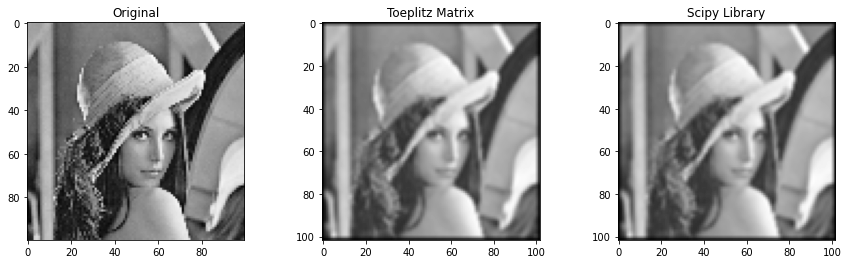

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(I,cmap='gray')
ax1.set_title('Original')
ax2.imshow(conv2d_result, cmap='gray')
ax2.set_title('Toeplitz Matrix')
ax3.imshow(result, cmap='gray')
ax3.set_title('Scipy Library')
f.set_figheight(4)
f.set_figwidth(15)
plt.show()


## Question 1c

### Number of multiplications in 2d Convolution = $(D_p)^2 * (D_k)^2$


In [12]:
D_p = I.shape[0] # Output Dimension
output_dim = I.shape[0] + F.shape[0] - 1
D_k = output_dim #Ouput Dimension

multi = D_p*D_p + D_k*D_k
print("No. of multiplications is: ", multi)


No. of multiplications is:  20404


## Question 1d - Processing Time comparison for lena.jpg

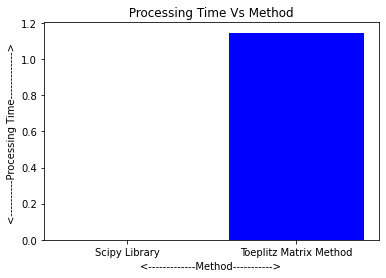

Time taken for Scipy Library Method is : 0.0
Time taken for Doubly Blocked Toeplitz Method is : 1.1457648277282715


In [13]:
x = ['Scipy Library', 'Toeplitz Matrix Method']
times = [lib_time, toep_time]
x_pos = [i for i in range(len(x))]
plt.bar(x_pos, times, color='blue')
plt.xlabel("<-------------Method-----------> ")
plt.ylabel("<----------Processing Time-------------> ")
plt.title(" Processing Time Vs Method ")
plt.xticks(x_pos, x)
plt.show()
print("Time taken for Scipy Library Method is :",lib_time)
print("Time taken for Doubly Blocked Toeplitz Method is :",toep_time)


## Question 2: Spatial seperable convolution

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
import time

### 2.a

In [14]:
imag = cv2.imread('lenna.tif',0)
#plt.imshow(img, cmap='gray')
#plt.show()

gaussian = np.array([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])/256.0
v = np.array([1,4,6,4,1])/16.0
h = np.array([1,4,6,4,1])/16.0

print('Multiplication of v and h vectors gives our gaussian filter')
np.matmul(v.reshape(-1,1), h.reshape(1, -1))

Multiplication of v and h vectors gives our gaussian filter


array([[0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.0234375 , 0.09375   , 0.140625  , 0.09375   , 0.0234375 ],
       [0.015625  , 0.0625    , 0.09375   , 0.0625    , 0.015625  ],
       [0.00390625, 0.015625  , 0.0234375 , 0.015625  , 0.00390625]])

In [15]:
def separable_conv(x_img, v, h):
    
    fil1, fil2 = v.reshape(-1,1), h.reshape(1,-1)
    
    pad1 = int((fil1.shape[0] - 1)/2)

    padded_img = np.pad(x_img, ((pad1, pad1), (0,0)), mode = 'constant')
    conv1 = [[np.sum(padded_img[i:i + fil1.shape[0], j] * fil1) for j in range(0, x_img.shape[1])] for i in range(0, x_img.shape[0])]
    conv1 = np.array(conv1)
    
    pad2 = int((fil2.shape[1] - 1)/2)
    padded_inp2 = np.pad(conv1, [(0,0), (pad2, pad2)], mode = 'constant')
    final_conv = np.zeros(conv1.shape)

    final_conv = [[np.sum(padded_inp2[i, j:j + fil2.shape[1]] * fil2) for j in range(0, conv1.shape[1])] for i in range(0, conv1.shape[0])]
    y_out = np.array(final_conv)
    return np.array(y_out)

In [18]:
t0 = time.time()
sep_con = separable_conv(imag, v, h)
time_sep = time.time() - t0

t0 = time.time()
lib_con = sig.convolve2d(imag, gaussian)
time_lib = time.time() - t0

print('Time for spatial separable convolution: ', time_sep)
print('Time for scipy library convolution: ', time_lib)

Time for spatial separable convolution:  12.17260217666626
Time for scipy library convolution:  0.10719084739685059


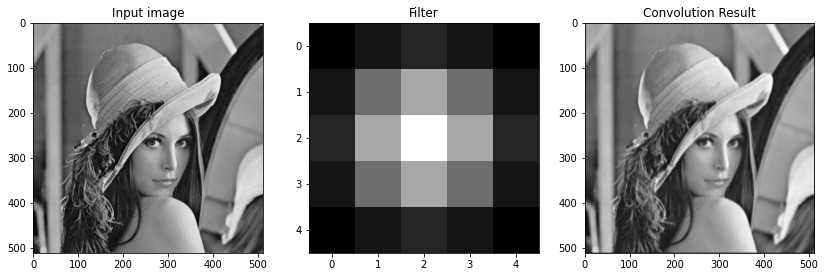

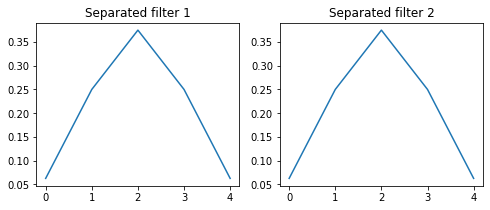

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(14, 14))
ax[0].imshow(imag, cmap='gray')
ax[0].set_title("Input image")
ax[1].imshow(gaussian, cmap='gray')
ax[1].set_title("Filter")
ax[2].imshow(sep_con, cmap='gray')
ax[2].set_title("Convolution Result")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(v)
ax[0].set_title("Separated filter 1")
ax[1].plot(h)
ax[1].set_title("Separated filter 2")
plt.show()

### 2.b Number of Multiplication


In [43]:
def count_multiplications(img_shape, fil_shape):
    n_1 = img_shape[0] * img_shape[1] * fil_shape[0]
    n_2 = (img_shape[0]+fil_shape[0]-1) * img_shape[1] * fil_shape[1]
    return n_1 + n_2

num_mult_ssconv = count_multiplications(imag.shape, gaussian.shape)
print("Number of multiplications in spatially separable convolution of lena.jpg and\n", gaussian, "=", num_mult_ssconv)

Number of multiplications in spatially separable convolution of lena.jpg and
 [[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]] = 2631680


## Q. 3. RGB to YUV and vice-versa


(a) Write python from scratch to convert RGB Image (lena.tif) to YUV color image using mathematical equation discussed in the class.

(b) Write python from scratch to convert  YUV  Image ( part(a)) to RGB color image using mathematical equation discussed in the class.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

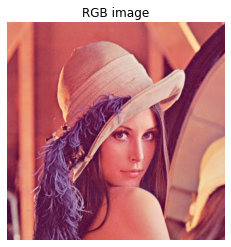

In [24]:
rgb_img = plt.imread('lenna.tif')

plt.imshow(rgb_img)
plt.axis('off')
plt.title('RGB image')
plt.show()

In [25]:
def gamma_correction(rgb):
    rgb_n = rgb/255.0
    rgb_gamma = np.where(rgb_n<0.018,rgb_n*4.5,1.099*(rgb_n**0.45) - 0.099)
    return rgb_gamma

### RGB to YUV conversion

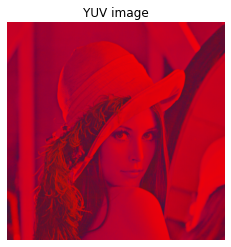

In [26]:
rgb_gamma = gamma_correction(rgb_img)

r_,g_,b_ = cv2.split(rgb_gamma)

y = 0.299*r_ + 0.587*g_ + 0.114*b_
u = 0.492*(b_ - y)
v = 0.877*(r_ - y)
# u = -0.147*r_ -0.289*g_ + 0.436*b_
# v = 0.615*r_ - 0.515*g_ -0.100*b_
yuv_img = np.stack((y,u,v),axis = 2)
yuv_img = np.where(yuv_img<0,0,yuv_img)

plt.imshow(yuv_img)
plt.axis('off')
plt.title('YUV image')
plt.show()

### YUV to RGB conversion

In [27]:
def gamma_decorrection(rgb_gamma):
    rgb = np.where(rgb_gamma<0.018,rgb_gamma/4.5,((rgb_gamma + 0.099)/1.099)**2.22)
    return rgb

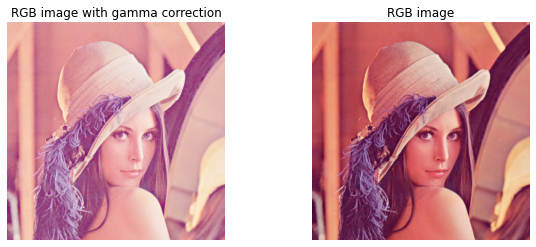

In [28]:
_r = y + 1.14*v 
_g = y - 0.394*u - 0.581*v
_b = y + 2.032*u
yuv2rgb_img = np.stack((_r,_g,_b),axis = 2)

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].imshow(yuv2rgb_img)
axs[0].axis('off')
axs[0].title.set_text('RGB image with gamma correction')

axs[1].imshow(gamma_decorrection(yuv2rgb_img))
axs[1].axis('off')
axs[1].title.set_text('RGB image')
plt.show()

# Q. 4. 

(a) Write python from scratch to convert RGB Image (lena.jpg)  to YCrCb color image using mathematical equation discussed in the class.

(b) Write python from scratch to convert   YCrCb  Image ( part(a)) to RGB color image using mathematical equation discussed in the class.

### RGB to YCbCr conversion

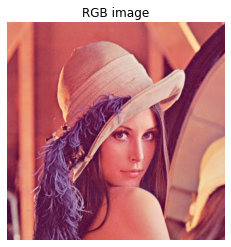

In [29]:
rgb_img = plt.imread('lenna.tif')

plt.imshow(rgb_img)
plt.axis('off')
plt.title('RGB image')
plt.show()

In [30]:
def gamma_correction_0to255(rgb):
    rgb_n = rgb/255.0
    rgb_gamma = np.where(rgb_n<0.018,rgb_n*4.5,1.099*(rgb_n**0.45) - 0.099) * 255
    return rgb_gamma

def gamma_decorrection_0to255(rgb_gamma):
    rgb_gamma_n = rgb_gamma/255
    rgb = np.where(rgb_gamma_n<0.018,rgb_gamma/4.5,((rgb_gamma_n + 0.099)/1.099)**2.22)
    return rgb

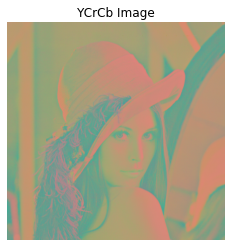

In [31]:
rgb_gamma = gamma_correction_0to255(rgb_img)

r_,g_,b_ = cv2.split(rgb_gamma)

y = 0.257*r_ + 0.504*g_ + 0.098*b_ + 16
cb = -0.148*r_ - 0.291*g_ + 0.439*b_ + 128
cr = 0.439*r_ - 0.368*g_ - 0.071*b_ + 128
ycrcb_img = np.array(np.stack((y,cr,cb),axis = 2),dtype = np.int32)

plt.imshow(ycrcb_img)
plt.axis('off')
plt.title('YCrCb Image')
plt.show()

## YCbCr to RGB conversion

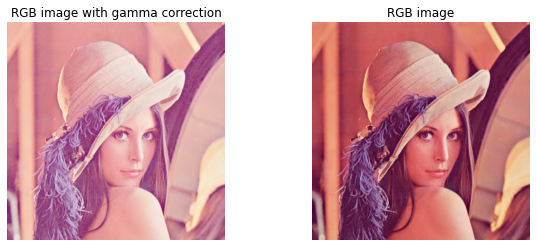

In [32]:
_r = 1.164*(y - 16) + 1.596*(cr - 128)
_g = 1.164*(y-16) - 0.813*(cr - 128) - 0.392*(cb-128)
_b = 1.164*(y-16) + 2.017*(cb - 128)
ycbcr2rgb_img = np.array(np.stack((_r,_g,_b),axis = 2),dtype = np.int32)

fig,axs = plt.subplots(1,2,figsize = (10,4))

axs[0].imshow(ycbcr2rgb_img)
axs[0].axis(False)
axs[0].title.set_text('RGB image with gamma correction')

axs[1].imshow(gamma_decorrection_0to255(ycbcr2rgb_img))
axs[1].axis(False)
axs[1].title.set_text('RGB image')
plt.show()

## Conversions done manually

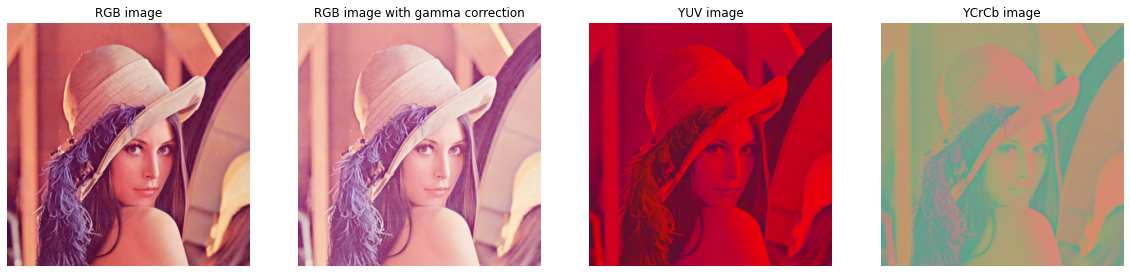

In [33]:
rgb_img = plt.imread('lenna.tif')
rgb_gamma = gamma_correction(rgb_img)

fig, axs = plt.subplots(1,4,figsize = (20,8))
axs[0].imshow(rgb_img)
axs[0].title.set_text('RGB image')
axs[0].axis('off')

axs[1].imshow(rgb_gamma)
axs[1].title.set_text('RGB image with gamma correction')
axs[1].axis('off')

axs[2].imshow(yuv_img)
axs[2].title.set_text('YUV image')
axs[2].axis('off')

axs[3].imshow(ycrcb_img)
axs[3].title.set_text('YCrCb image')
axs[3].axis('off')
plt.show()

## Conversions using openCV

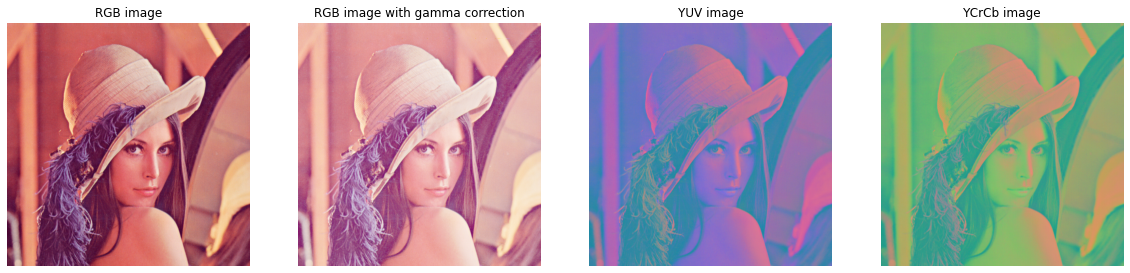

In [34]:
rgb_img = plt.imread('lenna.tif')
rgb_gamma = gamma_correction(rgb_img)

fig, axs = plt.subplots(1,4,figsize = (20,8))
axs[0].imshow(rgb_img)
axs[0].title.set_text('RGB image')
axs[0].axis('off')

axs[1].imshow(rgb_gamma)
axs[1].title.set_text('RGB image with gamma correction')
axs[1].axis('off')

axs[2].imshow(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV))
axs[2].title.set_text('YUV image')
axs[2].axis('off')

axs[3].imshow(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb))
axs[3].title.set_text('YCrCb image')
axs[3].axis('off')
plt.show()

## Question 5: 

### 5 a. RGB to HSV conversion

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time 

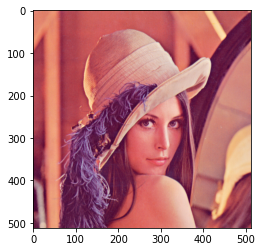

In [36]:
image = cv2.imread('lenna.tif')
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [37]:
def rgb_to_hsv(img):
    r = img[:,:,0]/255.
    g = img[:,:,1]/255.
    b = img[:,:,2]/255.

    theta = np.arccos(np.round(0.5*(2*r - g - b)/ np.sqrt((r-g)**2 + (r-b)*(g-b)), 4))*180/np.pi
    h = np.array([[theta[i,j] if b[i,j]<=g[i,j] else 360-theta[i,j] for j in range(theta.shape[1])] for i in range(theta.shape[0])])
    s = np.array([[1- 3/(r[i][j]+g[i][j]+b[i][j])*min(r[i][j],g[i][j],b[i][j]) for j in range(r.shape[1])] for i in range(r.shape[0])])
    i = (r+g+b)/3.0
    h /= 360.
    return np.stack((h,s,i), 2)


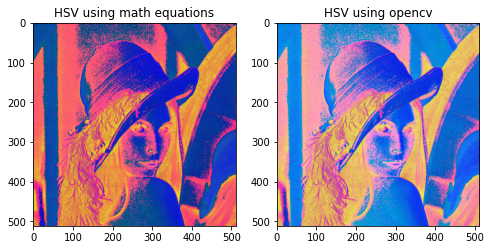

In [38]:
hsv_img = rgb_to_hsv(img_rgb)

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(hsv_img)
ax[0].set_title("HSV using math equations")
ax[1].imshow(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV_FULL))
ax[1].set_title("HSV using opencv")
plt.show()


### HSV to RGB conversion

In [39]:
def hsv_to_rgb(img):
    h = img[:,:,0]*360  #recover full angle
    s = img[:,:,1]
    i = img[:,:,2]
    
    h_n = h%120 # instead of subtracting 120 and 240 in each of the 3 cases
    h_n *= np.pi/180.
    e1 = i*(1 - s)
    e2 = i*(1 + s*np.cos(h_n)/np.cos(np.pi/3. - h_n) )
    e3 = 3*i - e1 - e2
    
    r = [[ e2[i,j] if h[i,j]<=120 else e1[i,j] if (h[i,j]>120 and h[i,j]<=240) else e3[i,j] for j in range(h.shape[1])] for i in range(h.shape[0])]
    g = [[ e3[i,j] if h[i,j]<=120 else e2[i,j] if (h[i,j]>120 and h[i,j]<=240) else e1[i,j] for j in range(h.shape[1])] for i in range(h.shape[0])]
    b = [[ e1[i,j] if h[i,j]<=120 else e3[i,j] if (h[i,j]>120 and h[i,j]<=240) else e2[i,j] for j in range(h.shape[1])] for i in range(h.shape[0])]
    #stack them and round to 3 decimal places 
    return np.round(np.stack((r,g,b), 2), 3)

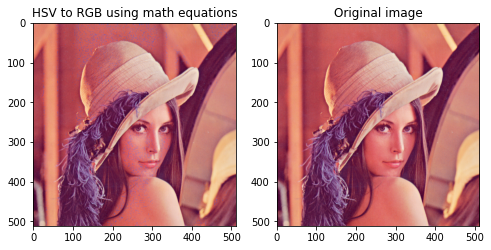

In [40]:
new_rgb = hsv_to_rgb(hsv_img)

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(new_rgb)
ax[0].set_title("HSV to RGB using math equations")
ax[1].imshow(img_rgb)
ax[1].set_title("Original image")
plt.show()
